### Objectives of the Notebook
---
In this notebook, we will learn how to use the XGBoost algorithm for working with time series data.

[XGBoost](https://xgboost.readthedocs.io/en/stable/) is a very popular implementation of [Gradient Boosting](https://interactivechaos.com/es/manual/tutorial-de-machine-learning/gradient-boosting) and has become the **de facto** benchmark for tabular data.

Despite its limitations for time series problems (for example, it cannot extrapolate a trend), the algorithm is very versatile, and every data scientist should be familiar with it.

The dataset we will work with in this notebook consists of a total of **426 time series** covering the period from January 2013 to September 2015. Therefore, we will work with **multivariate time series**.

Each of these **time series** represents the <u>**MONTHLY**</u> sales of **an item in a store and city**. The goal is to predict the <u>**TOTAL SALES FOR OCTOBER 2015**</u>.

By the end of the notebook, the student should be familiar with:

1. **The importance of establishing a benchmark (CORE IDEA)** when starting to work on a machine learning problem.
2. Efficiently using **pandas for dataset manipulation (pandas resampling, groupby, etc.)**.
3. **Combining information from different time series to generate variables (total sales of an item, total sales of all items in a store) to feed our XGBoost model (CORE IDEA).**
4. Identifying **self-explanatory variables (CORE IDEA)** and their main causes.
5. Understanding **the importance of rapid iteration (conducting many experiments) (CORE IDEA)** to test different hypotheses and constructed variables.

---

This notebook contains many advanced features that may require multiple readings for full comprehension. We believe that the sections marked with **CORE IDEA** will provide the most benefit to the student. Therefore, we encourage you to pay special attention to these ideas.


In this section, we make the main imports for the notebook. We will primarily work with **numpy**, **pandas**, **statsmodels**, and **XGBoost**.

In [ ]:
import os

import pandas as pd
import xgboost as xgb

In [ ]:
print(f"pandas version: {pd.__version__}")
print(f"xgboost version: {xgb.__version__}")

pandas version: 2.0.3
xgboost version: 2.0.3


In [ ]:
if pd.__version__ != "1.5.1":
    os.system("pip install pandas==1.5.1")

In [ ]:
if xgb.__version__ != "1.3.3":
    os.system("pip install xgboost==1.3.3")

In [ ]:
import pickle
import os

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install xgboost==1.3.3

In [ ]:
if xgb.__version__ != "1.3.3":
    os.system("pip install xgboost==1.3.3")

In [ ]:
print("Working with these versions of libraries\n")
print("-"*50)
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")
print(f"XGBoost version {xgb.__version__}")

Working with these versions of libraries

--------------------------------------------------
Numpy version 1.25.2
Pandas version 2.0.3
XGBoost version 2.0.3


In [ ]:
CWD = os.getcwd()
DATA_PATH = os.path.join(CWD, "data")

DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/M5. Machine Learning II/time_series/data"

FILE_NAME = "ts_kaggle_train.csv"
TRAIN_CSV_PATH = os.path.join(DATA_PATH, FILE_NAME)

Let’s load our dataset to get started with the EDA.

In [ ]:
df = pd.read_csv(TRAIN_CSV_PATH, index_col = 0)
df.sample(5)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
14135,2013-05-31,7_7893,21,7,6,7893,1432.0,1.0
4371,2015-10-31,25_5380,7,25,75,5380,NaN,NaN
10784,2013-09-30,50_20949,17,50,71,20949,5.0,30.0
1020,2015-01-31,16_5823,4,16,35,5823,2599.0,7.0
5134,2014-06-30,28_5821,7,28,35,5821,649.0,4.0


In [ ]:
df.tail()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
14479,2015-10-31,7_5822,21,7,35,5822,NaN,NaN
14480,2015-10-31,7_6185,21,7,30,6185,NaN,NaN
14481,2015-10-31,7_6497,21,7,28,6497,NaN,NaN
14482,2015-10-31,7_7856,21,7,28,7856,NaN,NaN
14483,2015-10-31,7_7893,21,7,6,7893,NaN,NaN


Let’s see what kind of data we have in our dataset.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   14484 non-null  object 
 1   unique_id              14484 non-null  object 
 2   city_id                14484 non-null  int64  
 3   shop_id                14484 non-null  int64  
 4   item_category_id       14484 non-null  int64  
 5   item_id                14484 non-null  int64  
 6   monthly_average_price  13262 non-null  float64
 7   monthly_sales          13756 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 1018.4+ KB


In [ ]:
df["date"] = pd.to_datetime(df["date"], format = "%Y-%m-%d")


### Benchmark Idea


In this notebook, we aim to establish a quick benchmark.

The fundamental reason for doing so is that real-world datasets are often complex, and we don't have the "luxury" of analyzing every single variable **before training our first model**.

Setting a benchmark helps us understand the starting point, i.e., **what is the minimum score for this dataset**.

Often, this benchmark can be a model trained with a few numeric columns (imputing missing values with the mean). It's not about having the best model; it's about training our initial model.

Once we know the starting point and have a **"functional" notebook**, we can begin experimenting with our dataset. By a **"functional notebook"**, we mean a script or notebook that we can execute in its entirety (including loading the dataset, preprocessing, train-test split, training, and prediction). In each experiment, we'll add new variables, try different imputations, and use various models while recording the scores we obtain. This way, we can assess the contribution of each variable and check if we're improving compared to the benchmark.

Since this notebook serves as a benchmark, we need to **narrow down** the specific implementations (to avoid going off track).

At a high level, we'll do the following:

1. Handle missing values.
2. Perform a brief exploratory data analysis (EDA) on the dataset.
3. Create some quick features for training.
4. Train the algorithm.
5. Evaluate the model.
6. Submit to Kaggle.



We have a total of 426 time series in the dataset

In [ ]:
df["unique_id"].nunique()

426

Let’s see what the minimum and maximum dates are in our dataset

In [ ]:
MIN_DATE = df["date"].min()
MAX_DATE = df["date"].max()

In [ ]:
print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}")

Min date is 2013-01-31 00:00:00
Max date is 2015-10-31 00:00:00


In [ ]:
df.isnull().sum()

date                        0
unique_id                   0
city_id                     0
shop_id                     0
item_category_id            0
item_id                     0
monthly_average_price    1222
monthly_sales             728
dtype: int64

<a id='impute'></a>
### Data Imputation


In [ ]:
sample_ts = "31_4249"

In [ ]:
df.shape

(14484, 8)

In [ ]:
df[df["unique_id"] == sample_ts]

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
5666,2013-01-31,31_4249,7,31,23,4249,1899.000000,2.0
5743,2013-02-28,31_4249,7,31,23,4249,1599.000000,5.0
5820,2013-03-31,31_4249,7,31,23,4249,1013.416000,6.0
5897,2013-04-30,31_4249,7,31,23,4249,1598.900000,10.0
5974,2013-05-31,31_4249,7,31,23,4249,1598.937500,8.0
6051,2013-06-30,31_4249,7,31,23,4249,1599.000000,4.0
6128,2013-07-31,31_4249,7,31,23,4249,1399.000000,4.0
6205,2013-08-31,31_4249,7,31,23,4249,1599.000000,2.0
6282,2013-09-30,31_4249,7,31,23,4249,1199.000000,5.0
6359,2013-10-31,31_4249,7,31,23,4249,929.075000,4.0


In [ ]:
df["monthly_sales"].fillna(0, inplace = True)

In [ ]:
df["monthly_average_price"] = df.groupby("unique_id", group_keys = False)["monthly_average_price"].apply(
    lambda series: series.backfill().ffill()
)

<ipython-input-23-41995bcc7a20>:2: FutureWarning: DataFrame.backfill/Series.backfill is deprecated. Use DataFrame.bfill/Series.bfill instead
  lambda series: series.backfill().ffill()


In [ ]:
df.isnull().sum()

date                     0
unique_id                0
city_id                  0
shop_id                  0
item_category_id         0
item_id                  0
monthly_average_price    0
monthly_sales            0
dtype: int64

In [ ]:
df.sort_values(["unique_id", "date"], ascending = True, inplace = True)

In [ ]:
df[df["unique_id"] == sample_ts]

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
5666,2013-01-31,31_4249,7,31,23,4249,1899.000000,2.0
5743,2013-02-28,31_4249,7,31,23,4249,1599.000000,5.0
5820,2013-03-31,31_4249,7,31,23,4249,1013.416000,6.0
5897,2013-04-30,31_4249,7,31,23,4249,1598.900000,10.0
5974,2013-05-31,31_4249,7,31,23,4249,1598.937500,8.0
6051,2013-06-30,31_4249,7,31,23,4249,1599.000000,4.0
6128,2013-07-31,31_4249,7,31,23,4249,1399.000000,4.0
6205,2013-08-31,31_4249,7,31,23,4249,1599.000000,2.0
6282,2013-09-30,31_4249,7,31,23,4249,1199.000000,5.0
6359,2013-10-31,31_4249,7,31,23,4249,929.075000,4.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   14484 non-null  datetime64[ns]
 1   unique_id              14484 non-null  object        
 2   city_id                14484 non-null  int64         
 3   shop_id                14484 non-null  int64         
 4   item_category_id       14484 non-null  int64         
 5   item_id                14484 non-null  int64         
 6   monthly_average_price  14484 non-null  float64       
 7   monthly_sales          14484 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 1018.4+ KB


In [ ]:
# Agrupar por mes y sumar las ventas
monthly_sales_sum = df.groupby(df['date'].dt.to_period("M"))['monthly_sales'].sum()

# Encontrar el mes con el mayor número de ventas
mes_max_ventas = monthly_sales_sum.idxmax().strftime('%B %Y')

# Obtener la cantidad vendida en ese mes
cantidad_vendida_max = monthly_sales_sum.max()

print(f"El mes con el mayor número de ventas ha sido {mes_max_ventas} con una cantidad vendida de {cantidad_vendida_max} unidades.")

El mes con el mayor número de ventas ha sido December 2014 con una cantidad vendida de 4874.0 unidades.


In [ ]:
# Agrupar por ciudad y sumar las ventas
city_sales_sum = df.groupby('city_id')['monthly_sales'].sum()

# Encontrar la ciudad con las mayores ventas
ciudad_max_ventas = city_sales_sum.idxmax()

print(f"El id de la ciudad con las mayores ventas es: {ciudad_max_ventas}")

El id de la ciudad con las mayores ventas es: 7


In [ ]:
# Agrupar por categoría y contar la cantidad de item_id únicos
category_unique_items = df.groupby('item_category_id')['item_id'].nunique()

# Encontrar la categoría con el mayor número de item_id diferentes
categoria_max_item_id = category_unique_items.idxmax()

# Obtener el total de item_id diferentes en esa categoría
total_item_id_diferentes = category_unique_items.max()

print(f"El id de la categoría con mayor número de item_id diferentes es: {categoria_max_item_id}")
print(f"El total de item_id diferentes en esa categoría es: {total_item_id_diferentes}")

El id de la categoría con mayor número de item_id diferentes es: 40
El total de item_id diferentes en esa categoría es: 24


<a id='eda'></a>
### EDA


Let’s perform a quick exploratory data analysis (EDA) to understand our time series and gather some ideas for future variables we’ll implement.

Since this notebook serves as a benchmark, we’ll explore the dataset in a very superficial manner. In subsequent runs, we’ll analyze the dataset in more detail, create new variables, and retrain our model.

<a id='eda_global_sales'></a>
### --> 1. EDA: Global Sales


In [ ]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2, lags = 14)
    plot_pacf(x = y, ax = ax3, lags = 14)

    plt.suptitle(t = title, fontsize = 20)

In [ ]:
y = df.set_index("date").resample("M")["monthly_sales"].sum()[:-1] # quitamos los registros de octubre

<ipython-input-32-16f16de67f7a>:1: FutureWarning: TimeGrouper.ax is deprecated and will be removed in a future version. Use Resampler.ax instead
  y = df.set_index("date").resample("M")["monthly_sales"].sum()[:-1] # quitamos los registros de octubre
<ipython-input-32-16f16de67f7a>:1: FutureWarning: TimeGrouper.indexer is deprecated and will be removed in a future version. Use Resampler.indexer instead.
  y = df.set_index("date").resample("M")["monthly_sales"].sum()[:-1] # quitamos los registros de octubre
<ipython-input-32-16f16de67f7a>:1: FutureWarning: TimeGrouper.obj is deprecated and will be removed in a future version. Use GroupBy.indexer instead.
  y = df.set_index("date").resample("M")["monthly_sales"].sum()[:-1] # quitamos los registros de octubre


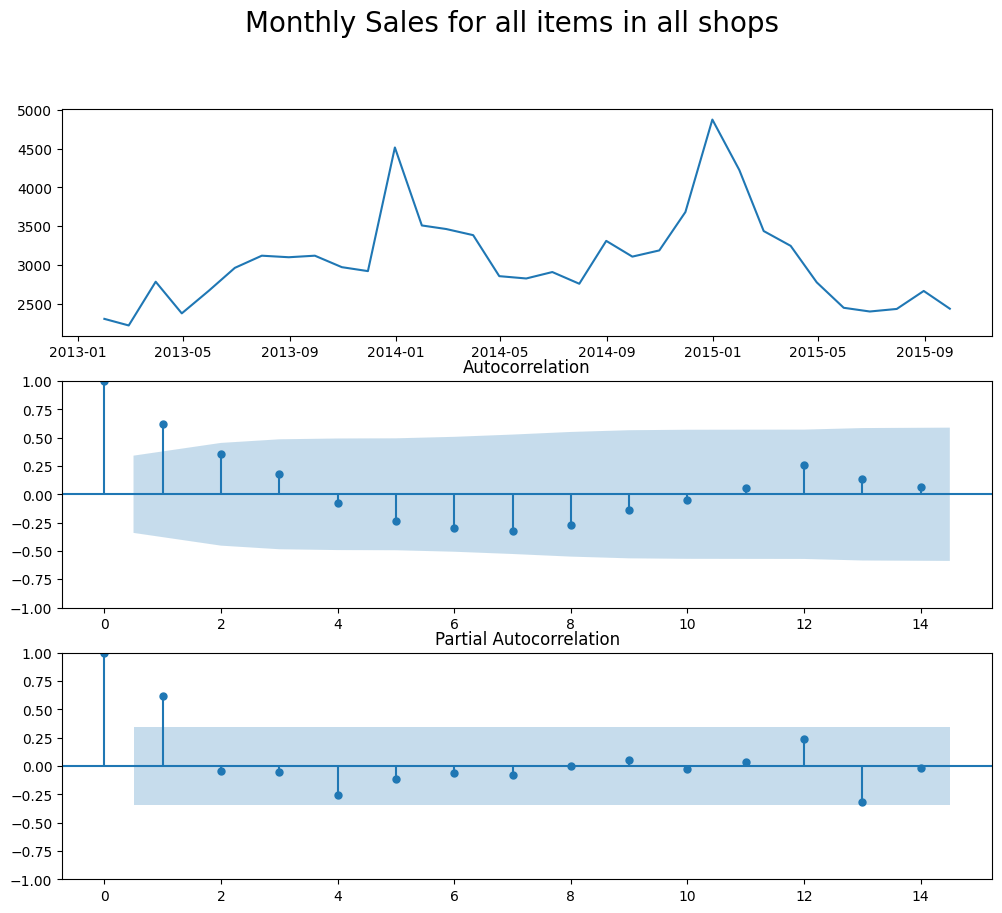

In [ ]:
plot_ts_acf_pacf(y = y, title = "Monthly Sales for all items in all shops");

**Important Note:** We are using the ACF (autocorrelation function) and PACF (partial autocorrelation function) plots, but we won't train an ARIMA model.

To address the problem at hand—dealing with over 400 different time series—we would need to train 400 ARIMAs (one model per time series). However, with the XGBoost algorithm, we can train a single model.

However, unlike ARIMA (which internally constructs the necessary variables), for XGBoost, we need to be explicit and provide all the necessary features.

From the previous plot, we can already observe that lag variables may be highly relevant.

**Idea for students:** You can try analyzing some of the 400 time series individually to understand their behavior.

Feel free to explore further, and let me know if you have any other questions! 😊📊

## feature engineering

In [ ]:
for col in ['date']:
  df['day'] =df[col].dt.day
  df['day_of_week'] = df['date'].dt.dayofweek
  #df['week'] = df[col].dt.week
  df['month'] = df[col].dt.month
  df['year'] = df[col].dt.year
  df['trim'] = df[col].dt.quarter

### Media Movil

In [ ]:
df["monthly_average_price_ma"] = df.groupby(["unique_id"])["monthly_average_price"].transform(
    lambda series:series.shift(1).rolling(window=3).mean())

In [ ]:
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,day,day_of_week,month,year,trim,monthly_average_price_ma
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,31,3,1,2013,1,NaN
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,28,3,2,2013,1,NaN
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,31,6,3,2013,1,NaN
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,30,1,4,2013,2,2099.035955
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,31,4,5,2013,2,2125.370130


<a id='build_ts_features'></a>
### Build Time Series Features (**CORE IDEA**)
[Volver al índice](#index)<br>

Given that we’ll need to iterate over our dataset many times, it’s important to encapsulate all the code into functions for reusability.

One of the key aspects will be variable generation.

As we’ve seen before, our dataset contains more than 400 Time Series.

Some of these Time Series can be grouped to extract new information.

For example, we can create variables like:

Total sales by ITEM_ID (the finest granularity).
Total sales by ITEM_CATEGORY_ID and SHOP_ID (a higher granularity than 1).
Total sales by SHOP_ID (a higher granularity).
And any intermediate combinations we want.

In [ ]:
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name,lag=1): # RS_ agregar lag
    assert "date" in df.columns.tolist(), "Date must be in df columns"
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])
    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("M")[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {target_column : new_name}
        )
    )
    i=1
    while i <= lag:
        gb_df_[f"{new_name}_lag{i}"] = gb_df_.groupby(gb_list)[new_name].transform(lambda series: series.shift(i))
        i+=1
    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)
    dfst = pd.merge(df, gb_df_, on = ["date"] + gb_list, how = "left")
    return dfst

In [ ]:
GB_LIST = ["item_id"]
TARGET_COLUMN = "monthly_sales"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
)
vars_ts_.head(1)

<ipython-input-41-3b87e5cd731e>:8: FutureWarning: TimeGrouper.ax is deprecated and will be removed in a future version. Use Resampler.ax instead
  .resample("M")[target_column]
<ipython-input-41-3b87e5cd731e>:8: FutureWarning: TimeGrouper.indexer is deprecated and will be removed in a future version. Use Resampler.indexer instead.
  .resample("M")[target_column]
<ipython-input-41-3b87e5cd731e>:5: FutureWarning: TimeGrouper.obj is deprecated and will be removed in a future version. Use GroupBy.indexer instead.
  df
<ipython-input-41-3b87e5cd731e>:9: FutureWarning: TimeGrouper.ax is deprecated and will be removed in a future version. Use Resampler.ax instead
  .apply(agg_func)
<ipython-input-41-3b87e5cd731e>:9: FutureWarning: TimeGrouper.indexer is deprecated and will be removed in a future version. Use Resampler.indexer instead.
  .apply(agg_func)
<ipython-input-41-3b87e5cd731e>:9: FutureWarning: TimeGrouper.obj is deprecated and will be removed in a future version. Use GroupBy.indexer 

Dropping columns that might cause target leakage item_id_monthly_sales_sum


,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,day,day_of_week,month,year,trim,monthly_average_price_ma,item_id_monthly_sales_sum_lag1
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,31,3,1,2013,1,NaN,NaN


In [ ]:
df=vars_ts_
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,day,day_of_week,month,year,trim,monthly_average_price_ma,item_id_monthly_sales_sum_lag1
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,31,3,1,2013,1,NaN,NaN
1,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,28,3,2,2013,1,NaN,30.0
2,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,31,6,3,2013,1,NaN,27.0
3,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,30,1,4,2013,2,2099.035955,30.0
4,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,31,4,5,2013,2,2125.370130,27.0


In [ ]:
GB_LIST = ["city_id", "shop_id"]
TARGET_COLUMN = "monthly_sales"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
)
vars_ts_.head(1)

<ipython-input-41-3b87e5cd731e>:8: FutureWarning: TimeGrouper.ax is deprecated and will be removed in a future version. Use Resampler.ax instead
  .resample("M")[target_column]
<ipython-input-41-3b87e5cd731e>:8: FutureWarning: TimeGrouper.indexer is deprecated and will be removed in a future version. Use Resampler.indexer instead.
  .resample("M")[target_column]
<ipython-input-41-3b87e5cd731e>:5: FutureWarning: TimeGrouper.obj is deprecated and will be removed in a future version. Use GroupBy.indexer instead.
  df
<ipython-input-41-3b87e5cd731e>:9: FutureWarning: TimeGrouper.ax is deprecated and will be removed in a future version. Use Resampler.ax instead
  .apply(agg_func)
<ipython-input-41-3b87e5cd731e>:9: FutureWarning: TimeGrouper.indexer is deprecated and will be removed in a future version. Use Resampler.indexer instead.
  .apply(agg_func)
<ipython-input-41-3b87e5cd731e>:9: FutureWarning: TimeGrouper.obj is deprecated and will be removed in a future version. Use GroupBy.indexer 

Dropping columns that might cause target leakage city_id_shop_id_monthly_sales_sum


,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,day,day_of_week,month,year,trim,monthly_average_price_ma,item_id_monthly_sales_sum_lag1,city_id_shop_id_monthly_sales_sum_lag1
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,31,3,1,2013,1,NaN,NaN,NaN


In [ ]:
df=vars_ts_
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,day,day_of_week,month,year,trim,monthly_average_price_ma,item_id_monthly_sales_sum_lag1,city_id_shop_id_monthly_sales_sum_lag1
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,31,3,1,2013,1,NaN,NaN,NaN
1,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,28,3,2,2013,1,NaN,30.0,137.0
2,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,31,6,3,2013,1,NaN,27.0,136.0
3,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,30,1,4,2013,2,2099.035955,30.0,150.0
4,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,31,4,5,2013,2,2125.370130,27.0,137.0


In [ ]:
GB_LIST = ["item_category_id", 'shop_id']
TARGET_COLUMN = "monthly_sales"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
)
vars_ts_.head(1)

<ipython-input-41-3b87e5cd731e>:8: FutureWarning: TimeGrouper.ax is deprecated and will be removed in a future version. Use Resampler.ax instead
  .resample("M")[target_column]
<ipython-input-41-3b87e5cd731e>:8: FutureWarning: TimeGrouper.indexer is deprecated and will be removed in a future version. Use Resampler.indexer instead.
  .resample("M")[target_column]
<ipython-input-41-3b87e5cd731e>:5: FutureWarning: TimeGrouper.obj is deprecated and will be removed in a future version. Use GroupBy.indexer instead.
  df
<ipython-input-41-3b87e5cd731e>:9: FutureWarning: TimeGrouper.ax is deprecated and will be removed in a future version. Use Resampler.ax instead
  .apply(agg_func)
<ipython-input-41-3b87e5cd731e>:9: FutureWarning: TimeGrouper.indexer is deprecated and will be removed in a future version. Use Resampler.indexer instead.
  .apply(agg_func)
<ipython-input-41-3b87e5cd731e>:9: FutureWarning: TimeGrouper.obj is deprecated and will be removed in a future version. Use GroupBy.indexer 

Dropping columns that might cause target leakage item_category_id_shop_id_monthly_sales_sum


,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,day,day_of_week,month,year,trim,monthly_average_price_ma,item_id_monthly_sales_sum_lag1,city_id_shop_id_monthly_sales_sum_lag1,item_category_id_shop_id_monthly_sales_sum_lag1
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,31,3,1,2013,1,NaN,NaN,NaN,NaN


In [ ]:
df=vars_ts_
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,day,day_of_week,month,year,trim,monthly_average_price_ma,item_id_monthly_sales_sum_lag1,city_id_shop_id_monthly_sales_sum_lag1,item_category_id_shop_id_monthly_sales_sum_lag1
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,31,3,1,2013,1,NaN,NaN,NaN,NaN
1,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,28,3,2,2013,1,NaN,30.0,137.0,96.0
2,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,31,6,3,2013,1,NaN,27.0,136.0,89.0
3,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,30,1,4,2013,2,2099.035955,30.0,150.0,111.0
4,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,31,4,5,2013,2,2125.370130,27.0,137.0,96.0


In [ ]:
GB_LIST = ["item_id"]
TARGET_COLUMN = "monthly_average_price"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
)

<ipython-input-41-3b87e5cd731e>:8: FutureWarning: TimeGrouper.ax is deprecated and will be removed in a future version. Use Resampler.ax instead
  .resample("M")[target_column]
<ipython-input-41-3b87e5cd731e>:8: FutureWarning: TimeGrouper.indexer is deprecated and will be removed in a future version. Use Resampler.indexer instead.
  .resample("M")[target_column]
<ipython-input-41-3b87e5cd731e>:5: FutureWarning: TimeGrouper.obj is deprecated and will be removed in a future version. Use GroupBy.indexer instead.
  df
<ipython-input-41-3b87e5cd731e>:9: FutureWarning: TimeGrouper.ax is deprecated and will be removed in a future version. Use Resampler.ax instead
  .apply(agg_func)
<ipython-input-41-3b87e5cd731e>:9: FutureWarning: TimeGrouper.indexer is deprecated and will be removed in a future version. Use Resampler.indexer instead.
  .apply(agg_func)
<ipython-input-41-3b87e5cd731e>:9: FutureWarning: TimeGrouper.obj is deprecated and will be removed in a future version. Use GroupBy.indexer 

Dropping columns that might cause target leakage item_id_monthly_average_price_sum


<a id='train_test_split'></a>
### Train Test Split
[Volver al índice](#index)<br>

In [ ]:
df.columns.tolist()

['date',
 'unique_id',
 'city_id',
 'shop_id',
 'item_category_id',
 'item_id',
 'monthly_average_price',
 'monthly_sales',
 'day',
 'day_of_week',
 'month',
 'year',
 'trim',
 'monthly_average_price_ma',
 'item_id_monthly_sales_sum_lag1',
 'city_id_shop_id_monthly_sales_sum_lag1',
 'item_category_id_shop_id_monthly_sales_sum_lag1']

In [ ]:
COLUMNS_TO_DROP = []

df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [ ]:
df.set_index("unique_id", inplace = True)

In [ ]:
df.sample(5)

,date,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,day,day_of_week,month,year,trim,monthly_average_price_ma,item_id_monthly_sales_sum_lag1,city_id_shop_id_monthly_sales_sum_lag1,item_category_id_shop_id_monthly_sales_sum_lag1
unique_id,,,,,,,,,,,,,,,,
25_7894,2013-10-31,7,25,6,7894,1490.00000,27.0,31,3,10,2013,4,1481.119048,155.0,251.0,26.0
52_16209,2015-02-28,18,52,65,16209,329.00000,4.0,28,5,2,2015,1,327.333333,12.0,33.0,4.0
6_17717,2015-05-31,21,6,79,17717,1001.50463,30.0,31,6,5,2015,2,1253.905767,259.0,102.0,30.0
18_5823,2014-11-30,5,18,35,5823,2599.00000,22.0,30,6,11,2014,4,2599.000000,154.0,44.0,23.0
31_12860,2015-08-31,7,31,40,12860,99.00000,2.0,31,0,8,2015,3,122.333333,2.0,327.0,55.0


In [ ]:
train_index = sorted(list(df["date"].unique()))[:-2]

valida_index = [sorted(list(df["date"].unique()))[-2]]

test_index = [sorted(list(df["date"].unique()))[-1]]

In [ ]:
print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
print(f"Our validation index is {valida_index}\n")
print(f"Our test/prediction index is {test_index}\n")

Our train index is [Timestamp('2013-01-31 00:00:00'), Timestamp('2013-02-28 00:00:00')] - ... - [Timestamp('2015-07-31 00:00:00'), Timestamp('2015-08-31 00:00:00')]

Our validation index is [Timestamp('2015-09-30 00:00:00')]

Our test/prediction index is [Timestamp('2015-10-31 00:00:00')]



In [ ]:
X_train = df[df["date"].isin(train_index)].drop(['monthly_sales', "date"], axis=1)
Y_train = df[df["date"].isin(train_index)]['monthly_sales']

X_valida = df[df["date"].isin(valida_index)].drop(['monthly_sales', "date"], axis=1)
Y_valida = df[df["date"].isin(valida_index)]['monthly_sales']

X_test = df[df["date"].isin(test_index)].drop(['monthly_sales', "date"], axis = 1)
Y_test = df[df["date"].isin(test_index)]['monthly_sales']

<a id='model_train'></a>
### Model Train


In [ ]:
model = xgb.XGBRegressor(eval_metric = "rmse", seed = 175)

model.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_valida, Y_valida)], verbose = True)

[0]	validation_0-rmse:6.49029	validation_1-rmse:6.03421
[1]	validation_0-rmse:5.52888	validation_1-rmse:4.95555
[2]	validation_0-rmse:4.93265	validation_1-rmse:4.29876
[3]	validation_0-rmse:4.55465	validation_1-rmse:3.82271
[4]	validation_0-rmse:4.30988	validation_1-rmse:3.55587
[5]	validation_0-rmse:4.14101	validation_1-rmse:3.39406
[6]	validation_0-rmse:4.02945	validation_1-rmse:3.31146
[7]	validation_0-rmse:3.94355	validation_1-rmse:3.25784
[8]	validation_0-rmse:3.87503	validation_1-rmse:3.21378
[9]	validation_0-rmse:3.79455	validation_1-rmse:3.13320
[10]	validation_0-rmse:3.72224	validation_1-rmse:3.11048
[11]	validation_0-rmse:3.66679	validation_1-rmse:3.11041
[12]	validation_0-rmse:3.61304	validation_1-rmse:3.13179
[13]	validation_0-rmse:3.55334	validation_1-rmse:3.11801
[14]	validation_0-rmse:3.51165	validation_1-rmse:3.10750
[15]	validation_0-rmse:3.47933	validation_1-rmse:3.06813
[16]	validation_0-rmse:3.44714	validation_1-rmse:3.04763
[17]	validation_0-rmse:3.41566	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<a id='model_evaluation'></a>
### Model Evaluation (**CORE IDEA**)
[Volver al índice](#index)<br>

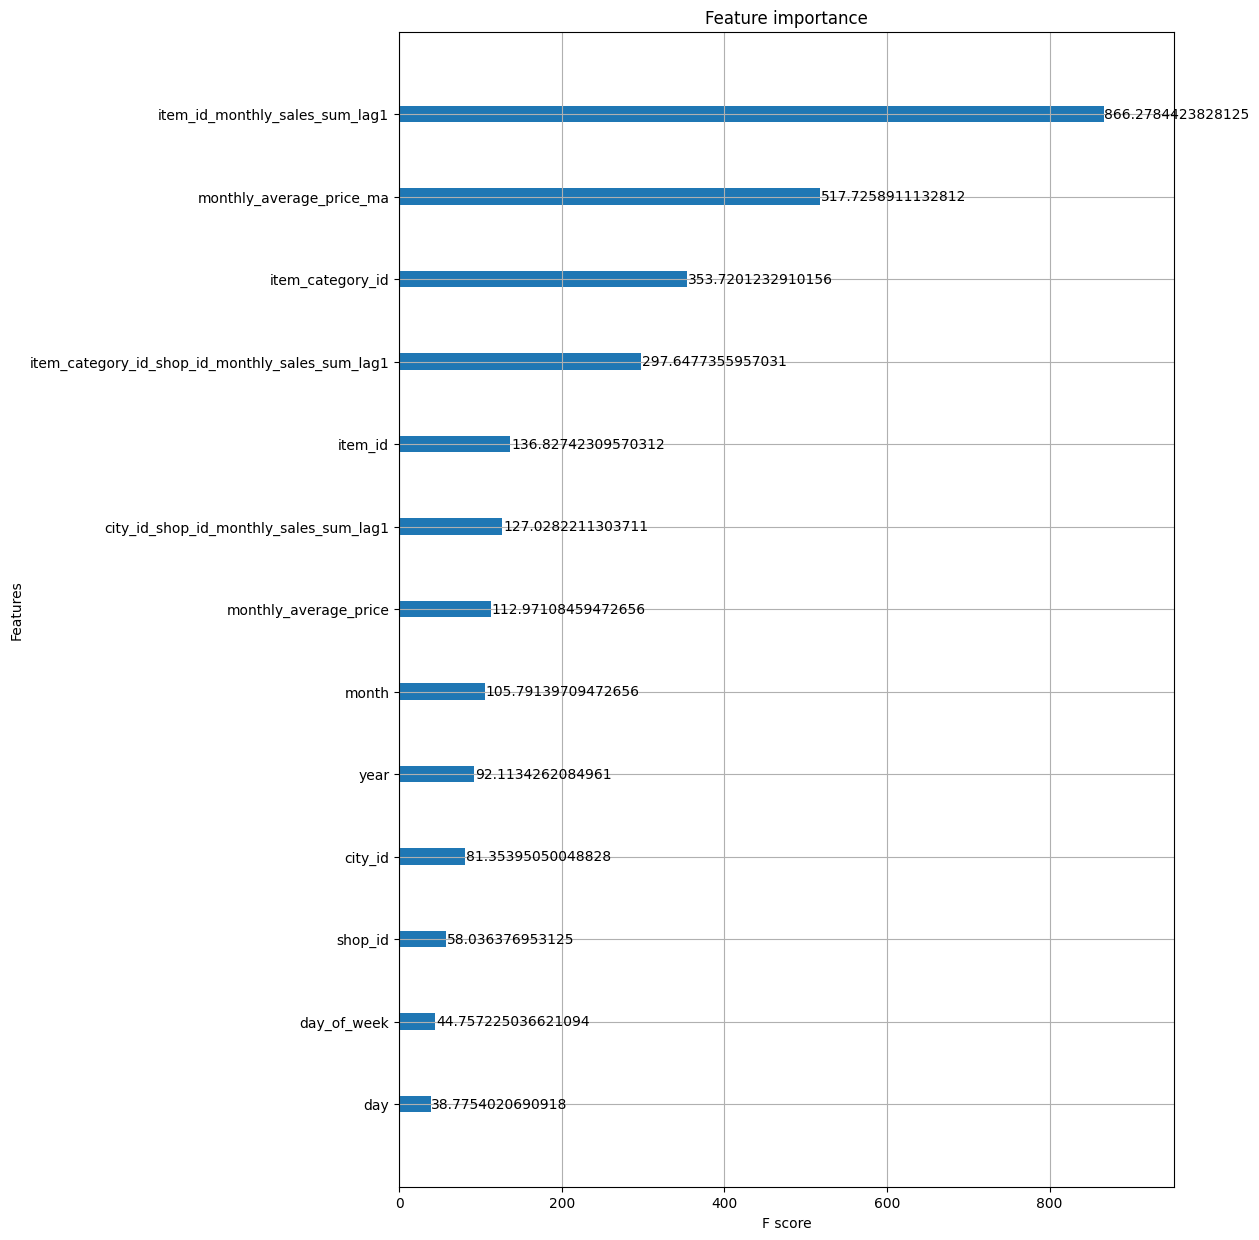

In [ ]:
fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

<a id='prediction'></a>
### Prediction

In this section, we are going to use the trained model to make a prediction and then submit it to Kaggle.

In [ ]:
if "monthly_sales" in X_test.columns:
    X_test.drop("monthly_sales", axis = 1, inplace = True)

Y_test_predict = model.predict(X_test)
X_test["monthly_sales"] = Y_test_predict

In [ ]:
X_test.reset_index(inplace = True)

In [ ]:
Y_train_predict = model.predict(X_train)
Y_valida_predict = model.predict(X_valida)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

In [ ]:
print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

Train RMSE: 2_317
Validation RMSE: 2_924


In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Entregable 3/sub.csv'.format(rmse_train, rmse_valida)

In [ ]:
(
    X_test[["unique_id", "monthly_sales"]]
    .to_csv(f"submission_train_{rmse_train}_valida_{rmse_valida}.csv", index = False)
)

In [ ]:
X_test[["unique_id", "monthly_sales"]].to_csv(file_path, index=False)

### Conclusión

In this notebook, we have explored the importance in Machine Learning of using a benchmark model when facing a new dataset for the first time.

Establishing the benchmark helps us understand the starting point.

When training a model, we already have a functional notebook that allows us to enter the following loop:

Do a bit more Exploratory Data Analysis (EDA).
Build new variables.
Test these variables in the model.
Save the score to assess improvement (Kaggle Submit).
Return to step 1."
